In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
from package import filter_function as ff

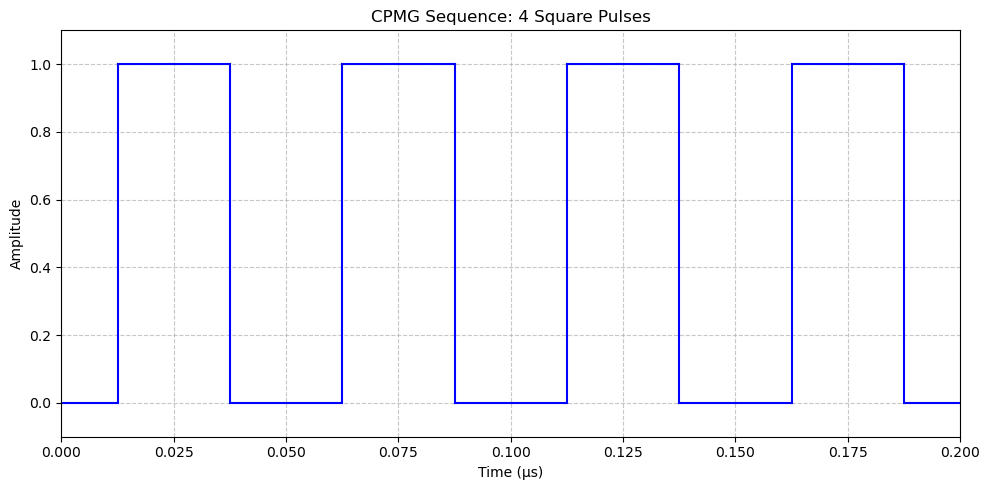

True
True
True
[0.125 0.375 0.625 0.875]


In [2]:
# Visualization of CPMG-like pulse sequence

def plot_square_pulses(t_k, n, tau_p, total_time=None):
    """
    Plot n square pulses of length tau_p that begin at each t_k.
    
    Parameters:
    -----------
    t_k : array-like
        Array of start times for each pulse
    n : int
        Number of pulses to plot
    tau_p : float
        Duration of each square pulse
    total_time : float, optional
        Total time range for the plot. If None, calculated from t_k and tau_p
    
    Returns:
    --------
    matplotlib.figure.Figure
        The created figure object
    """
    # Ensure t_k is a NumPy array and take first n elements
    t_k = np.asarray(t_k)[:n]
    
    # Determine plot time range if not specified
    if total_time is None:
        total_time = np.max(t_k + tau_p) * 1.1
    
    # Create the figure and axis
    fig, ax = plt.subplots(figsize=(10, 5))
    
    # # Plot vertical dashed lines at each t_k before square pulses
    # for start_time in t_k:
    #     ax.axvline(x=start_time, color='r', linestyle='--', alpha=0.5, label='Start Times' if start_time == t_k[0] else "")

    ax.plot([0, t_k[0]], [0, 0], 'b-')  # Initial flat line
    ax.plot([t_k[-1]+tau_p, total_time], [0, 0], 'b-') 
    
    # Plot each square pulse
    for i,start_time in enumerate(t_k):
        ax.plot([start_time, start_time], [0, 1], 'b-')  # Rising edge
        ax.plot([start_time + tau_p, start_time + tau_p], [1, 0], 'b-')  # Falling edge
        ax.plot([start_time, start_time + tau_p], [1, 1], 'b-')  # Top of pulse
        if i < n-1:
            ax.plot([start_time + tau_p, t_k[i+1]], [0, 0], 'b-')

    
    # Set plot details
    ax.set_xlim(0, total_time)
    ax.set_ylim(-0.1, 1.1)
    ax.set_xlabel('Time (µs)')
    ax.set_ylabel('Amplitude')
    ax.set_title("CPMG Sequence: " + f'{n} Square Pulses')
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Add legend for start times
    # ax.legend()
    
    plt.tight_layout()
    return fig

##### Set Parameters #####
N = 4 # number of pi pulses
tau_p = 0.025 # pulse width in microseconds (µs)
wait_time = 0.025 # wait time between pulses in microseconds (µs)
T = N*(tau_p+wait_time) # total experiment time in microseconds (µs)

pulse_beginning = np.linspace((T/N-tau_p)/2, T*(1-1/(2*N))-(tau_p/2), N)  # timing for the beginning of each pulse.

# Create and show the plot
fig = plot_square_pulses(pulse_beginning, N, tau_p, total_time=T)
plt.show()

# Check the time points To make sure they are correct
print(pulse_beginning[0] == (T/N-tau_p)/2)
print(pulse_beginning[-1] == T*(1-1/(2*N))-(tau_p/2))
holder = []
for i in range(N-1):
    holder.append(np.isclose(pulse_beginning[i] + tau_p + wait_time, pulse_beginning[i+1]))
print(all(holder))

t_center = np.linspace((T/N)/2, T*(1-1/(2*N)), N)
# print(T)
# print(t_center)
print(t_center/T)

# Comparing Filter Functions

The Filter function, $F_N(\omega, t)$, is characterized by the underlying $\pi$ pulse sequence. For the sake of integrating to compute the coherence profile, $C(t)$, $F_N(\omega, t)$ is often assumed to be a delta function peaked at $\omega_0 = \frac{N \pi}{t}$. However, we can be more explicit. Whenever the $\pi$ pulses are instaneous, (i.e. when $\tau_pi$=0), then a closed form expression for the filter function exists:

$$
F_N(\omega,t)= 16 \sin^4\left(\frac{\omega T}{4N}\right) \sec^2\left(\frac{\omega T}{2N}\right) \begin{cases} 
\sin^2\left(\frac{\omega T}{2}\right) & \text{if } N \text{ is even} \\
\cos^2\left(\frac{\omega T}{2}\right) & \text{if } N \text{ is odd}
\end{cases} 
$$

This approximate filter function is `ff.filter_function_approx`. 

In the case of finite-width $\pi$ pulses, the exact expression for $F_N(\omega, t)$ is given by:
$$

F_{N}(\omega,t) =\Big|1+(-1)^{N+1}e^{i\omega t}+2\sum_{k=1}^N(-1)^k e^{i\omega t_{k}}\cos\left(\omega \tau_{\pi}/2\right)\Big|^{2}
$$

This is implemented in `ff.filter_function_finite`. Due to the summation over N, you will see that computation time scales approximately linearly with N, which you can see below.

Below, you will see a comparison of the two representations of the filter function. You can see when the pulse width, `tau_p`, is 0, that the approximation is exact, but as the pulse width begins to grow, the filter functions diverge. As he number of pulses, N, increases, the pulse width relative to the total experiment time shrinks, and you can see the approximation become closer to the true values around the first resonance.

False
Iteration 1 (n=1) took 1.6521 seconds
False
Iteration 2 (n=8) took 0.4427 seconds
False
Iteration 3 (n=128) took 4.3457 seconds
False
Iteration 4 (n=256) took 8.4543 seconds
False
Iteration 5 (n=512) took 15.1631 seconds


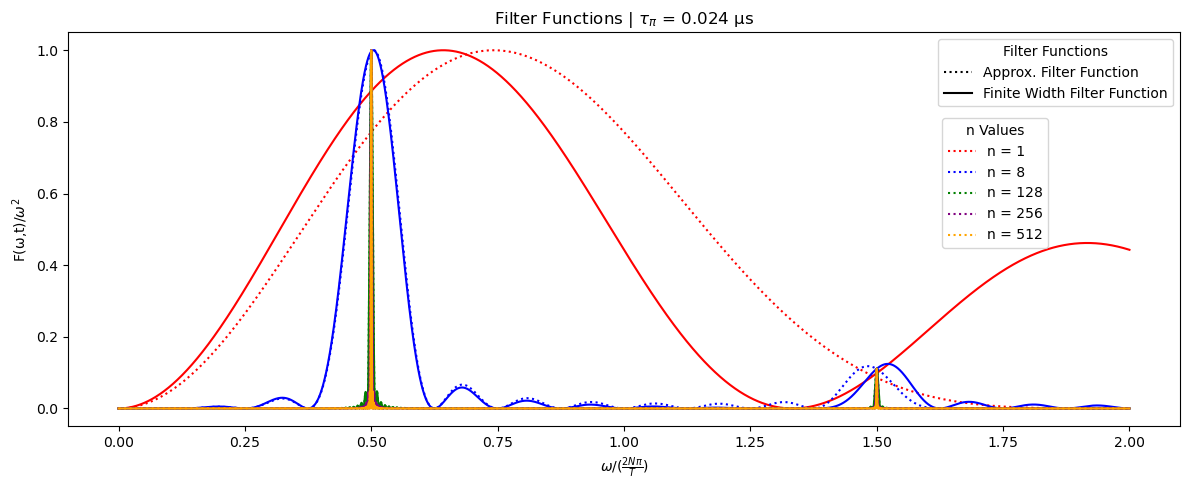

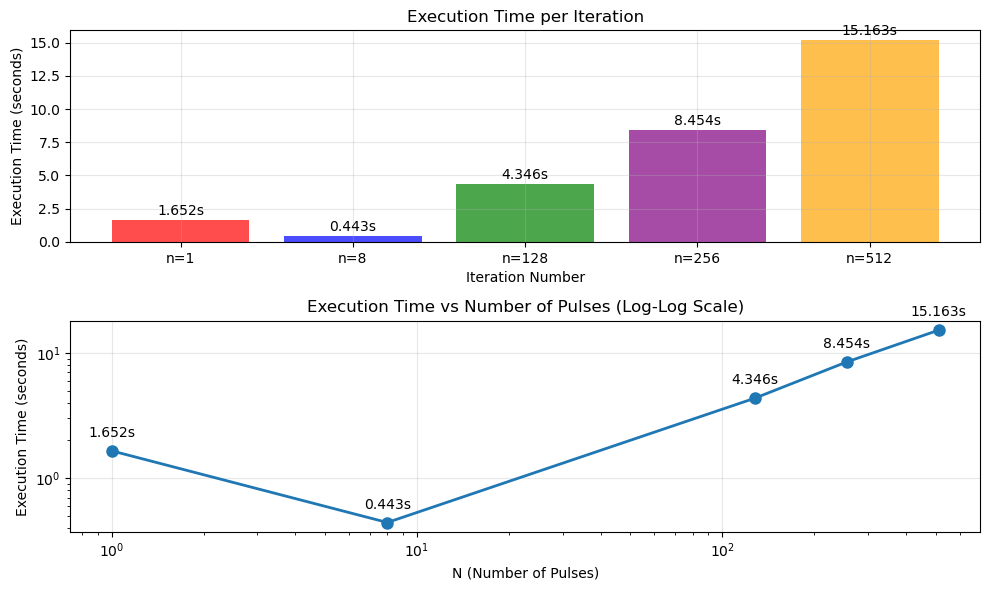


TIMING SUMMARY
Total execution time: 30.0580 seconds
Average time per iteration: 6.0116 seconds
Fastest iteration: 0.4427 seconds (n=8)
Slowest iteration: 15.1631 seconds (n=512)
Time complexity trend: O(n^0.43), R² = 0.643


In [3]:
##### Set Parameters #####
tau_p = 0.024 # Set pulse width in microseconds (µs)
wait_time = 0.024 # Set wait time between pulses in microseconds (µs)
Ns = [1, 8, 128, 256, 512] # Different numbers of pulses to compare
########################################################################

colors = ['red', 'blue', 'green', 'purple', 'orange', 'brown', 'pink', 'gray', 'cyan', 'magenta']

# Lists to store timing data
iteration_times = []
n_values_for_timing = []

fig2 = plt.figure(num=2, figsize=(12, 5))

# Create empty lists to store handles and labels for N values
n_handles, n_labels = [], []

# Create black lines for filter function legend (these won't be plotted yet)
approx_black_line = plt.Line2D([0], [0], color='black', linestyle=':', label='Approx. Filter Function')
finite_black_line = plt.Line2D([0], [0], color='black', linestyle='-', label='Finite Filter Function')
filter_handles = [approx_black_line, finite_black_line]
filter_labels = ['Approx. Filter Function', 'Finite Width Filter Function']

for i, n in enumerate(Ns):
    # Start timing this iteration
    start_time = time.time()
    
    color = colors[i % len(colors)]
    T = n*(tau_p+wait_time)
    first_resonance = np.pi * n / T
    num_resonances = 1
    # omega = np.linspace(10**-2, (2*num_resonances)*first_resonance, 10**6)
    # omega = np.logspace(-4, 8, 10**6)
    omega = np.linspace(10**-2, (2*n*np.pi/T)*2, 10**6)
   
    plot_me1 = ff.filter_function_approx(omega, n, T)/omega**2
    plot_me2 = ff.filter_function_finite(omega, n, T, tau_p, method='numba')/omega**2
    
    ########## Prints TRUE if The FW-FF is close to the Approx. FF
    print(np.all(np.isclose(plot_me1,plot_me2)))  
   
    # Plot with color but don't add to combined legend
    approx_line = plt.plot(omega/(2*n*np.pi/T), plot_me1/np.max(plot_me1), color=color, linestyle=":")[0]
    finite_line = plt.plot(omega/(2*n*np.pi/T), plot_me2/np.max(plot_me2), color=color, linestyle="-")[0]
    
    # Add to N values legend
    n_handles.append(approx_line)  # We only need one line per N value for the N legend
    n_labels.append(f"n = {n}")
    
    # End timing and store results
    end_time = time.time()
    iteration_time = end_time - start_time
    iteration_times.append(iteration_time)
    n_values_for_timing.append(n)
    
    print(f"Iteration {i+1} (n={n}) took {iteration_time:.4f} seconds")

# Adjust subplot position to make room for legends
plt.subplots_adjust(right=0.75)
plt.ylabel(r'F(ω,t)/$ω^2$')
plt.xlabel(r'$\omega / (\frac{2N \pi}{T})$')

# Create the first legend for N values (colors)
n_legend = plt.legend(n_handles, n_labels,
                      loc='upper left',
                      bbox_to_anchor=(0.78, 0.8),
                     title="n Values")

# Create the second legend for filter function types (line styles)
filter_legend = plt.legend(filter_handles, filter_labels,
                          title="Filter Functions")

# Add both legends to the figure
plt.gca().add_artist(n_legend)
plt.title("Filter Functions | "+r"$\tau_\pi$"+" = "+str(tau_p)+" μs")
plt.tight_layout()
plt.show()

# Create a separate figure for timing analysis
fig3 = plt.figure(num=3, figsize=(10, 6))
plt.subplot(2, 1, 1)
bars = plt.bar(range(len(Ns)), iteration_times, color=colors[:len(Ns)], alpha=0.7)
plt.xlabel('Iteration Number')
plt.ylabel('Execution Time (seconds)')
plt.title('Execution Time per Iteration')
plt.xticks(range(len(Ns)), [f'n={n}' for n in Ns])
plt.grid(True, alpha=0.3)

# Add value labels on top of bars
for i, (bar, time_val) in enumerate(zip(bars, iteration_times)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(iteration_times)*0.01, 
             f'{time_val:.3f}s', ha='center', va='bottom')

# Second subplot: timing vs N value (log scale)
plt.subplot(2, 1, 2)
plt.loglog(n_values_for_timing, iteration_times, 'o-', linewidth=2, markersize=8)
plt.xlabel('N (Number of Pulses)')
plt.ylabel('Execution Time (seconds)')
plt.title('Execution Time vs Number of Pulses (Log-Log Scale)')
plt.grid(True, alpha=0.3)

# Add value labels
for n, time_val in zip(n_values_for_timing, iteration_times):
    plt.annotate(f'{time_val:.3f}s', (n, time_val), 
                textcoords="offset points", xytext=(0,10), ha='center')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "="*50)
print("TIMING SUMMARY")
print("="*50)
print(f"Total execution time: {sum(iteration_times):.4f} seconds")
print(f"Average time per iteration: {np.mean(iteration_times):.4f} seconds")
print(f"Fastest iteration: {min(iteration_times):.4f} seconds (n={n_values_for_timing[np.argmin(iteration_times)]})")
print(f"Slowest iteration: {max(iteration_times):.4f} seconds (n={n_values_for_timing[np.argmax(iteration_times)]})")

if len(iteration_times) > 1:
    # Calculate if there's a trend
    from scipy import stats
    slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(n_values_for_timing), np.log(iteration_times))
    print(f"Time complexity trend: O(n^{slope:.2f}), R² = {r_value**2:.3f}")

Comparing methods for N = 32
Omega array size: 1000000
Number of runs per method: 5

Testing method: 'numba'
  Run 1: 1.0977 seconds
  Run 2: 1.0065 seconds
  Run 3: 1.0191 seconds
  Run 4: 1.0736 seconds
  Run 5: 1.0436 seconds

Testing method: 'numpy'
  Run 1: 1.1822 seconds
  Run 2: 1.2776 seconds
  Run 3: 1.1973 seconds
  Run 4: 1.2156 seconds
  Run 5: 1.1763 seconds

Testing method: 'numpy_array'
  Run 1: 2.0981 seconds
  Run 2: 1.1272 seconds
  Run 3: 1.3541 seconds
  Run 4: 1.1398 seconds
  Run 5: 1.3562 seconds

TIMING COMPARISON SUMMARY
NUMBA:
  Mean:   1.0481 ± 0.0338 seconds
  Median: 1.0436 seconds
  Range:  1.0065 - 1.0977 seconds
NUMPY:
  Mean:   1.2098 ± 0.0365 seconds
  Median: 1.1973 seconds
  Range:  1.1763 - 1.2776 seconds
NUMPY_ARRAY:
  Mean:   1.4151 ± 0.3556 seconds
  Median: 1.3541 seconds
  Range:  1.1272 - 2.0981 seconds

Fastest method: NUMBA

Speedup factors (relative to fastest):
  numba: 1.00x
  numpy: 1.15x
  numpy_array: 1.35x

RESULT COMPARISON (relative

/tmp/ipykernel_46195/2104849979.py:121: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax2.boxplot(valid_data, labels=valid_methods_for_plot, patch_artist=True)


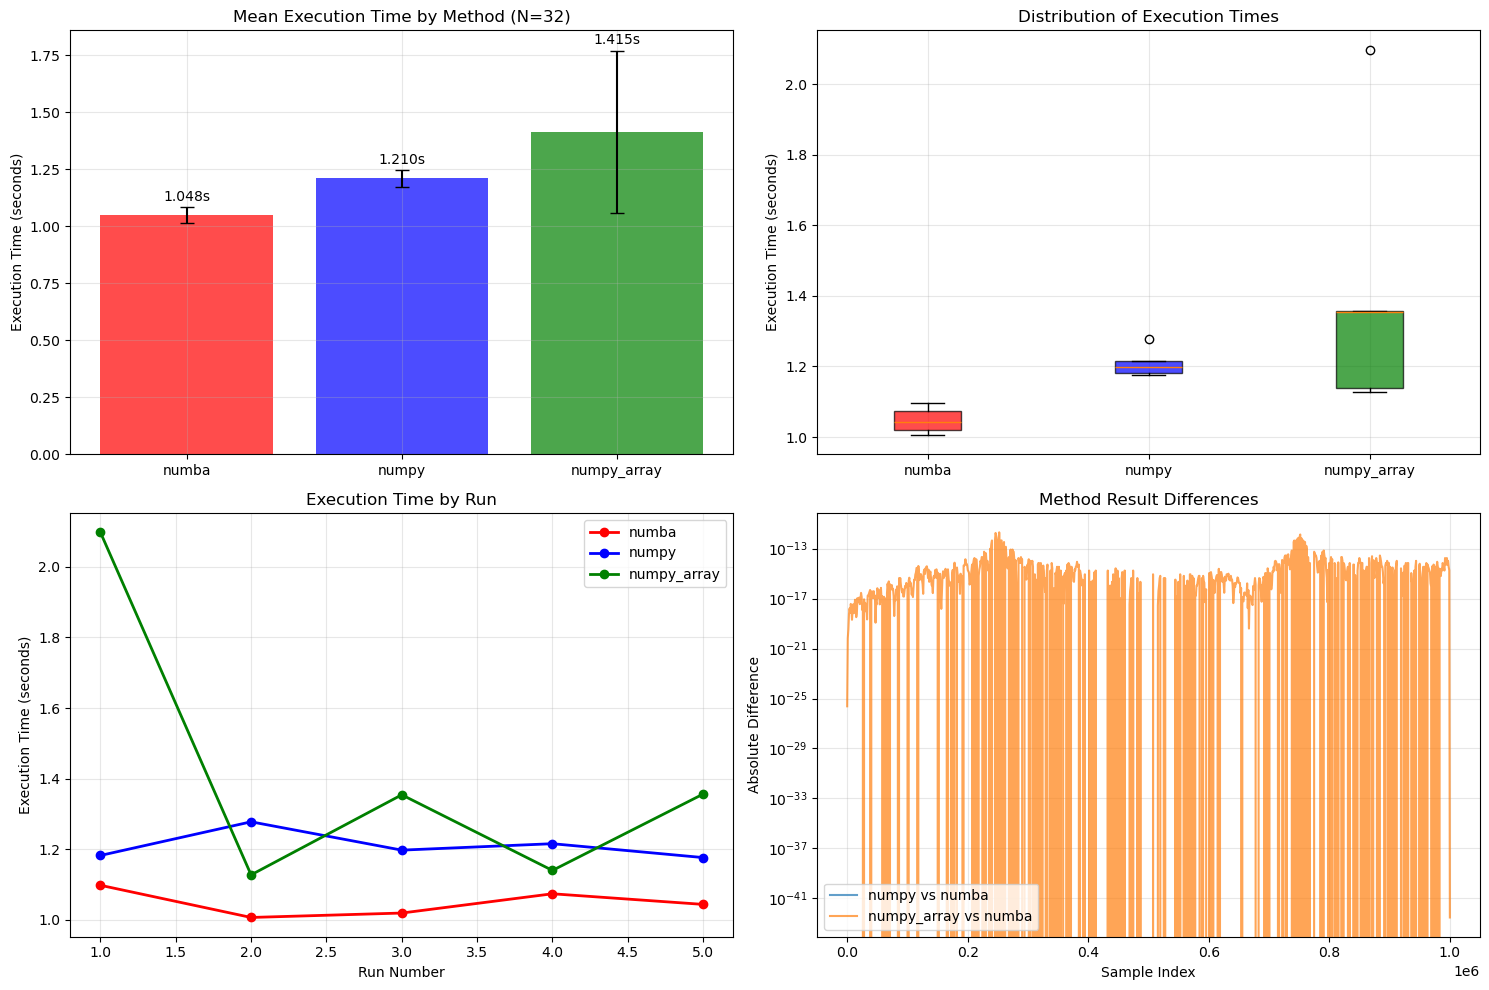


ADDITIONAL ANALYSIS
Input omega array size: 7.63 MB
Estimated peak memory per method: ~22.89 MB

RECOMMENDATION:
• Use 'numba' method for best performance
• Numba JIT compilation provides significant speedup
• numba is 1.4x faster than numpy_array


In [4]:
##### Set Parameters #####
tau_p = 0.024  # Set pulse width in microseconds (µs)
wait_time = 0.024  # Set wait time between pulses in microseconds (µs)
N_fixed = 32  # Fixed N value for method comparison
methods = ['numba', 'numpy', 'numpy_array']  # Methods to compare
num_runs = 5  # Number of runs per method for averaging
########################################################################

colors = ['red', 'blue', 'green']
method_colors = dict(zip(methods, colors))

# Calculate parameters
T = N_fixed * (tau_p + wait_time)
omega = np.linspace(10**-2, (2*N_fixed*np.pi/T)*2, 10**6)

print(f"Comparing methods for N = {N_fixed}")
print(f"Omega array size: {len(omega)}")
print(f"Number of runs per method: {num_runs}")
print("="*60)

# Storage for timing results
method_times = {method: [] for method in methods}
method_results = {}

# Run timing tests
for method in methods:
    print(f"\nTesting method: '{method}'")
    
    for run in range(num_runs):
        start_time = time.time()
        
        try:
            # Call the filter function with the specified method
            result = ff.filter_function_finite(omega, N_fixed, T, tau_p, method=method)
            
            end_time = time.time()
            execution_time = end_time - start_time
            method_times[method].append(execution_time)
            
            # Store result from first run for comparison
            if run == 0:
                method_results[method] = result
                
            print(f"  Run {run+1}: {execution_time:.4f} seconds")
            
        except Exception as e:
            print(f"  Run {run+1}: ERROR - {str(e)}")
            method_times[method].append(np.nan)

# Calculate statistics
method_stats = {}
for method in methods:
    valid_times = [t for t in method_times[method] if not np.isnan(t)]
    if valid_times:
        method_stats[method] = {
            'mean': np.mean(valid_times),
            'std': np.std(valid_times),
            'min': np.min(valid_times),
            'max': np.max(valid_times),
            'median': np.median(valid_times)
        }
    else:
        method_stats[method] = {
            'mean': np.nan, 'std': np.nan, 'min': np.nan, 
            'max': np.nan, 'median': np.nan
        }

# Print summary
print("\n" + "="*60)
print("TIMING COMPARISON SUMMARY")
print("="*60)
for method in methods:
    stats_dict = method_stats[method]
    if not np.isnan(stats_dict['mean']):
        print(f"{method.upper()}:")
        print(f"  Mean:   {stats_dict['mean']:.4f} ± {stats_dict['std']:.4f} seconds")
        print(f"  Median: {stats_dict['median']:.4f} seconds")
        print(f"  Range:  {stats_dict['min']:.4f} - {stats_dict['max']:.4f} seconds")
    else:
        print(f"{method.upper()}: FAILED - No valid timing data")

# Find fastest method
valid_methods = [m for m in methods if not np.isnan(method_stats[m]['mean'])]
if len(valid_methods) > 1:
    fastest_method = min(valid_methods, key=lambda m: method_stats[m]['mean'])
    print(f"\nFastest method: {fastest_method.upper()}")
    
    # Calculate speedup factors
    fastest_time = method_stats[fastest_method]['mean']
    print("\nSpeedup factors (relative to fastest):")
    for method in valid_methods:
        speedup = method_stats[method]['mean'] / fastest_time
        print(f"  {method}: {speedup:.2f}x")

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Subplot 1: Bar chart of mean execution times
ax1 = axes[0, 0]
valid_methods_for_plot = [m for m in methods if not np.isnan(method_stats[m]['mean'])]
if valid_methods_for_plot:
    means = [method_stats[method]['mean'] for method in valid_methods_for_plot]
    stds = [method_stats[method]['std'] for method in valid_methods_for_plot]
    method_colors_plot = [method_colors[method] for method in valid_methods_for_plot]
    
    bars = ax1.bar(valid_methods_for_plot, means, yerr=stds, 
                   color=method_colors_plot, alpha=0.7, capsize=5)
    ax1.set_ylabel('Execution Time (seconds)')
    ax1.set_title(f'Mean Execution Time by Method (N={N_fixed})')
    ax1.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, mean_val, std_val in zip(bars, means, stds):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + std_val + max(means)*0.01,
                f'{mean_val:.3f}s', ha='center', va='bottom')

# Subplot 2: Box plot of all timing data
ax2 = axes[0, 1]
valid_data = [method_times[method] for method in valid_methods_for_plot if valid_methods_for_plot]
if valid_data:
    bp = ax2.boxplot(valid_data, labels=valid_methods_for_plot, patch_artist=True)
    for patch, color in zip(bp['boxes'], method_colors_plot):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    ax2.set_ylabel('Execution Time (seconds)')
    ax2.set_title('Distribution of Execution Times')
    ax2.grid(True, alpha=0.3)

# Subplot 3: Individual run times
ax3 = axes[1, 0]
for i, method in enumerate(valid_methods_for_plot):
    valid_times = [t for t in method_times[method] if not np.isnan(t)]
    run_numbers = list(range(1, len(valid_times) + 1))
    ax3.plot(run_numbers, valid_times, 'o-', color=method_colors[method], 
             label=method, linewidth=2, markersize=6)

ax3.set_xlabel('Run Number')
ax3.set_ylabel('Execution Time (seconds)')
ax3.set_title('Execution Time by Run')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Subplot 4: Results comparison (if multiple methods succeeded)
ax4 = axes[1, 1]
if len(valid_methods_for_plot) > 1:
    # Compare results between methods
    reference_method = valid_methods_for_plot[0]
    reference_result = method_results[reference_method]
    
    print(f"\nRESULT COMPARISON (relative to {reference_method}):")
    
    for method in valid_methods_for_plot[1:]:
        if method in method_results:
            diff = np.abs(method_results[method] - reference_result)
            max_diff = np.max(diff)
            mean_diff = np.mean(diff)
            rel_error = mean_diff / np.mean(np.abs(reference_result))
            
            print(f"  {method} vs {reference_method}:")
            print(f"    Max absolute difference: {max_diff:.2e}")
            print(f"    Mean absolute difference: {mean_diff:.2e}")
            print(f"    Mean relative error: {rel_error:.2e}")
            
            # Plot difference
            sample_indices = np.linspace(0, len(diff)-1, min(1000, len(diff)), dtype=int)
            ax4.semilogy(sample_indices, diff[sample_indices], 
                        label=f'{method} vs {reference_method}', alpha=0.7)
    
    ax4.set_xlabel('Sample Index')
    ax4.set_ylabel('Absolute Difference')
    ax4.set_title('Method Result Differences')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
else:
    ax4.text(0.5, 0.5, 'Insufficient data\nfor result comparison', 
             ha='center', va='center', transform=ax4.transAxes, fontsize=12)
    ax4.set_title('Result Comparison')

plt.tight_layout()
plt.show()

# Additional analysis: Memory usage estimation
print("\n" + "="*60)
print("ADDITIONAL ANALYSIS")
print("="*60)
omega_size_mb = omega.nbytes / (1024**2)
print(f"Input omega array size: {omega_size_mb:.2f} MB")
print(f"Estimated peak memory per method: ~{omega_size_mb * 3:.2f} MB")  # Rough estimate

# Performance recommendations
if len(valid_methods_for_plot) > 1:
    print(f"\nRECOMMENDATION:")
    fastest = min(valid_methods_for_plot, key=lambda m: method_stats[m]['mean'])
    if fastest == 'numba':
        print("• Use 'numba' method for best performance")
        print("• Numba JIT compilation provides significant speedup")
    elif fastest == 'numpy':
        print("• Use 'numpy' method for good performance and stability")  
        print("• Pure NumPy is reliable and well-optimized")
    elif fastest == 'numpy_array':
        print("• Use 'numpy_array' method - optimized array operations")
        print("• Good balance of performance and memory efficiency")
        
    slowest = max(valid_methods_for_plot, key=lambda m: method_stats[m]['mean'])
    speedup_factor = method_stats[slowest]['mean'] / method_stats[fastest]['mean']
    print(f"• {fastest} is {speedup_factor:.1f}x faster than {slowest}")